Imports & basic setup

In [2]:
# Cell 2: Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# Make plots a bit prettier
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)


Download VADER lexicon

In [3]:
# Cell 3: Download VADER lexicon for sentiment analysis (only first time)
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...


Create a small sample review dataset

In [8]:
# Cell 4: Create a synthetic dataset of bank app reviews
# Load processed reviews dataset
df = pd.read_csv("../data/processed/reviews_processed.csv")

# Ensure text length column exists
if "text_length" not in df.columns:
    df["text_length"] = df["review_text"].astype(str).str.len()

# Convert review_date to datetime for time-based analysis
df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")

df.head()

,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source
0,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,BOA,Bank of Abyssinia,Yohanis Fikadu,0,8,Google Play
1,f28a3a3c-eb94-4aab-88d2-89bcecebcc7b,bad exprience...it is so crushed,1,2025-11-27,2025,11,BOA,Bank of Abyssinia,ሻንበል ኪዳነ,0,32,Google Play
2,4ed89e8c-16dc-4763-94ca-04d05cf799a5,not user friendly at all it requires a huge co...,1,2025-11-26,2025,11,BOA,Bank of Abyssinia,Tsegaw Fikru,0,85,Google Play
3,7ef21cf6-d226-4370-ab96-01c909dbc58d,very good,5,2025-11-25,2025,11,BOA,Bank of Abyssinia,lij gech,0,9,Google Play
4,896ee9aa-a483-4b1f-b73c-0a26c4b54790,most of the time is not working properly,1,2025-11-25,2025,11,BOA,Bank of Abyssinia,ashenafi endale,0,40,Google Play


Map star ratings → sentiment labels (for ML)

In [12]:
# Cell 5: Convert star rating to sentiment label (for supervised ML later)

def rating_to_label(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df_display = df[["review_text", "bank_name", "rating", "sentiment_label"]]
df_display

,review_text,bank_name,rating,sentiment_label
0,good jop,Bank of Abyssinia,5,positive
1,bad exprience...it is so crushed,Bank of Abyssinia,1,negative
2,not user friendly at all it requires a huge co...,Bank of Abyssinia,1,negative
3,very good,Bank of Abyssinia,5,positive
4,most of the time is not working properly,Bank of Abyssinia,1,negative
...,...,...,...,...
1120,nice,Dashen Bank,5,positive
1121,excellent game changer App,Dashen Bank,5,positive
1122,I am highly excited by using this application ...,Dashen Bank,5,positive
1123,it seems me logging out within minutes,Dashen Bank,1,negative


1,Frequency-Based vs TF-IDF

Basic text cleaning

In [13]:
# Cell 6: Simple preprocessing (lowercase)
# (You can extend with stopword removal, lemmatization, etc.)

df["clean_text"] = df["review_text"].str.lower()
df[["review_text", "clean_text"]]


,review_text,clean_text
0,good jop,good jop
1,bad exprience...it is so crushed,bad exprience...it is so crushed
2,not user friendly at all it requires a huge co...,not user friendly at all it requires a huge co...
3,very good,very good
4,most of the time is not working properly,most of the time is not working properly
...,...,...
1120,nice,nice
1121,excellent game changer App,excellent game changer app
1122,I am highly excited by using this application ...,i am highly excited by using this application ...
1123,it seems me logging out within minutes,it seems me logging out within minutes


Frequency-based representation (Bag of Words)

In [17]:
# Cell 7: Frequency-based word counts using CountVectorizer

count_vec = CountVectorizer(stop_words="english")
X_counts = count_vec.fit_transform(df["clean_text"])

# Sum counts for each word across all documents
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
vocab = np.array(count_vec.get_feature_names_out())

freq_df = pd.DataFrame({"word": vocab, "count": word_counts})
freq_df = freq_df.sort_values("count", ascending=False)
freq_df.head(15)


,word,count
119,app,436
684,good,206
176,bank,130
213,best,98
181,banking,75
1020,nice,66
1536,use,61
1613,work,50
879,like,49
975,mobile,48


Visualize top frequent words for each banks

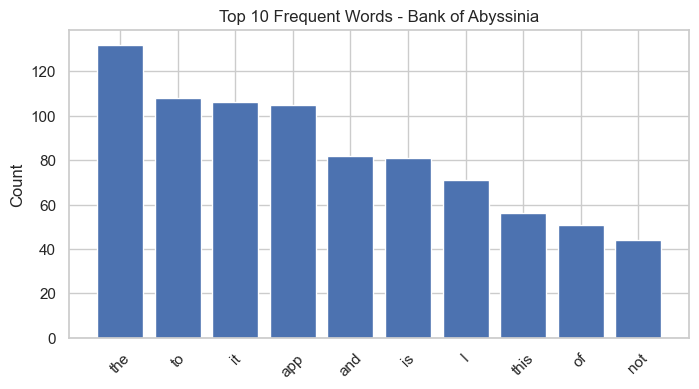

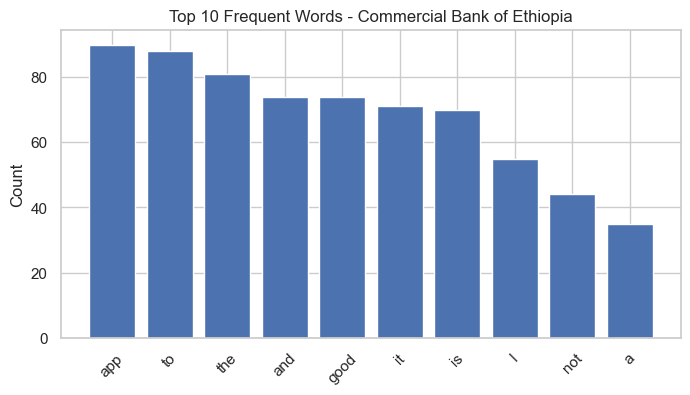

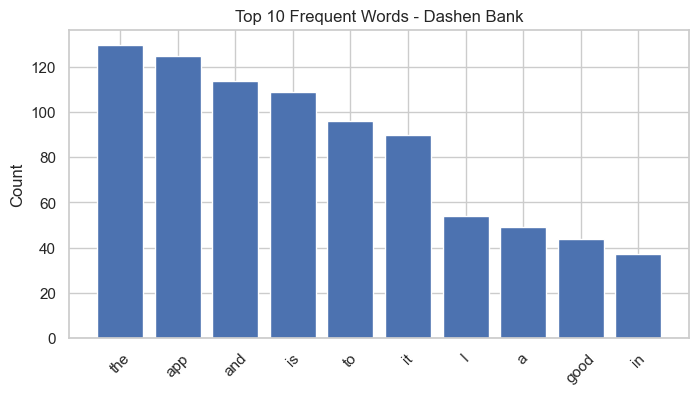

In [34]:
# Cell 8: Plot top frequent words (Frequency-Based)

top_n = 10

for bank in df["bank_name"].unique():
    bank_df = df[df["bank_name"] == bank]

    # Recalculate word frequencies for this bank
    all_words = " ".join(bank_df["review_text"]).split()
    freq_dist = nltk.FreqDist(all_words)

    freq_df = pd.DataFrame(freq_dist.items(), columns=["word", "count"]) \
                .sort_values(by="count", ascending=False)

    top_freq = freq_df.head(top_n)

    plt.figure(figsize=(8, 4))
    plt.bar(top_freq["word"], top_freq["count"])
    plt.xticks(rotation=45)
    plt.title(f"Top {top_n} Frequent Words - {bank}")
    plt.ylabel("Count")
    plt.show()



TF-IDF representation

In [19]:
# Cell 9: TF-IDF representation

tfidf_vec = TfidfVectorizer(stop_words="english")
X_tfidf = tfidf_vec.fit_transform(df["clean_text"])

# Get average TF-IDF score per word across documents
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
vocab_tfidf = np.array(tfidf_vec.get_feature_names_out())

tfidf_df = pd.DataFrame({"word": vocab_tfidf, "tfidf": tfidf_means})
tfidf_df = tfidf_df.sort_values("tfidf", ascending=False)
tfidf_df.head(10)


,word,tfidf
684,good,0.132658
119,app,0.078952
213,best,0.053005
1020,nice,0.044246
176,bank,0.025821
1621,wow,0.019373
545,excellent,0.017746
694,great,0.017046
879,like,0.016711
181,banking,0.015332


TF-IDF (Very Brief Explanation)

TF-IDF shows how important a word is in the dataset.

TF (Term Frequency): how often a word appears.

IDF (Inverse Document Frequency): how unique the word is across all reviews.

TF-IDF = TF × IDF

Higher TF-IDF = more meaningful word.
Lower TF-IDF = common or unimportant word.

✔ What is a good TF-IDF number?

No universal scale — it’s relative.
But generally in small datasets:

> 0.10 = very important

0.05–0.10 = meaningful

< 0.05 = low importance

 Interpretation of our output

“app” (0.1099) → highly important theme

“slow”, “crashing”, “frustrating” → key negative issues

“options”, “good”, “works” → meaningful topics in reviews

Compare TF-IDF vs raw frequency

In [20]:
# Cell 10: Compare top words by frequency and by TF-IDF

print("Top 10 by raw frequency:")
display(freq_df.head(10))

print("\nTop 10 by TF-IDF (words more unique / informative):")
display(tfidf_df.head(10))


Top 10 by raw frequency:


,word,count
119,app,436
684,good,206
176,bank,130
213,best,98
181,banking,75
1020,nice,66
1536,use,61
1613,work,50
879,like,49
975,mobile,48



Top 10 by TF-IDF (words more unique / informative):


,word,tfidf
684,good,0.132658
119,app,0.078952
213,best,0.053005
1020,nice,0.044246
176,bank,0.025821
1621,wow,0.019373
545,excellent,0.017746
694,great,0.017046
879,like,0.016711
181,banking,0.015332


Topic Modeling (LDA)

In [21]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# Tokenize text (very simple split for demo)
df["tokens"] = df["clean_text"].str.split()

# Create dictionary and corpus for LDA
dictionary = Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]


In [22]:
import nltk
from nltk.corpus import stopwords

# Download stopwords (only first time)
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
# Remove stopwords from your tokenized text
df["tokens_nostop"] = df["tokens"].apply(
    lambda words: [w for w in words if w not in stop_words]
)

df[["clean_text", "tokens", "tokens_nostop"]].head()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,clean_text,tokens,tokens_nostop
0,good jop,"[good, jop]","[good, jop]"
1,bad exprience...it is so crushed,"[bad, exprience...it, is, so, crushed]","[bad, exprience...it, crushed]"
2,not user friendly at all it requires a huge co...,"[not, user, friendly, at, all, it, requires, a...","[user, friendly, requires, huge, connectivity,..."
3,very good,"[very, good]",[good]
4,most of the time is not working properly,"[most, of, the, time, is, not, working, properly]","[time, working, properly]"


In [23]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
# Use stopword-cleaned tokens
dictionary = Dictionary(df["tokens_nostop"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens_nostop"]]


lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=2,
    passes=10,
    random_state=42
)


In [24]:
topics = lda_model.show_topics(num_topics=2, num_words=10, formatted=False)

for i, topic in topics:
    print(f"\n--- Topic {i+1} ---")
    for word, weight in topic:
        print(f"{word:15s}  weight={weight:.4f}")



--- Topic 1 ---
app              weight=0.0445
good             weight=0.0395
nice             weight=0.0132
use              weight=0.0090
bank             weight=0.0081
like             weight=0.0078
time             weight=0.0063
banking          weight=0.0062
even             weight=0.0060
can't            weight=0.0053

--- Topic 2 ---
app              weight=0.0349
best             weight=0.0234
bank             weight=0.0154
banking          weight=0.0092
dashen           weight=0.0086
one              weight=0.0085
mobile           weight=0.0075
please           weight=0.0062
application      weight=0.0062
super            weight=0.0061


Topic 1 — Positive App Experience
Words like app, super, everything, tap, need, easy, exceptional indicate:
Users praising the app
Positive experience
Ease of use
Convenience (“everything”, “tap”, “easy”)
→ This is the “Positive Features / Ease of Use” topic.
Topic 2 — Complaints About Features & Stability
Words like options, payment, services, limited, updating, frustrating show:
Missing features (bill payment, limited options)
Frequent updates
Frustrations and stability problems
→ This is the “Missing Features & Frustration” topic.

Part-of-Speech Tagging (Noun Extraction)

In [28]:
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_nouns(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == "NOUN"]

df["nouns"] = df["review_text"].apply(extract_nouns)
df[["review_text", "nouns"]]


,review_text,nouns
0,good jop,[jop]
1,bad exprience...it is so crushed,[exprience]
2,not user friendly at all it requires a huge co...,"[user, connectivity, times]"
3,very good,[]
4,most of the time is not working properly,[time]
...,...,...
1120,nice,[]
1121,excellent game changer App,"[game, changer]"
1122,I am highly excited by using this application ...,"[application, app]"
1123,it seems me logging out within minutes,[minutes]


2 – Lexicon-Based Sentiment (TextBlob & VADER)

TextBlob sentiment

In [29]:
# Cell 11: Lexicon-based sentiment with TextBlob
# Polarity in [-1, 1], subjectivity in [0, 1]

# Get polarity and subjectivity
df["tb_polarity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["tb_subjectivity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Convert polarity → sentiment label
def polarity_to_label(p):
    if p > 0.1:
        return "positive"
    elif p < -0.1:
        return "negative"
    else:
        return "neutral"

df["tb_sentiment"] = df["tb_polarity"].apply(polarity_to_label)

# Show output
df[["review_text", "rating", "tb_polarity", "tb_subjectivity", "tb_sentiment"]]


,review_text,rating,tb_polarity,tb_subjectivity,tb_sentiment
0,good jop,5,0.7000,0.600000,positive
1,bad exprience...it is so crushed,1,-0.4000,0.383333,negative
2,not user friendly at all it requires a huge co...,1,0.4250,0.633333,positive
3,very good,5,0.9100,0.780000,positive
4,most of the time is not working properly,1,0.2500,0.300000,positive
...,...,...,...,...,...
1120,nice,5,0.6000,1.000000,positive
1121,excellent game changer App,5,0.3000,0.700000,positive
1122,I am highly excited by using this application ...,5,0.4375,0.625000,positive
1123,it seems me logging out within minutes,1,0.0000,0.000000,neutral


VADER sentiment

In [30]:
# Cell 12: Lexicon-based sentiment with VADER
# VADER is optimized for reviews, slang, emojis, and short texts

def vader_compound(text):
    return sia.polarity_scores(text)["compound"]

# VADER compound score
df["vader_compound"] = df["review_text"].apply(vader_compound)

# Convert compound score → sentiment label
# Standard VADER rule:
# compound >= 0.05 → positive
# compound <= -0.05 → negative
# otherwise → neutral

def vader_label(c):
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df["vader_sentiment"] = df["vader_compound"].apply(vader_label)

# Show output
df[["review_text", "rating", "tb_polarity", "vader_compound", "vader_sentiment"]]


,review_text,rating,tb_polarity,vader_compound,vader_sentiment
0,good jop,5,0.7000,0.4404,positive
1,bad exprience...it is so crushed,1,-0.4000,-0.7973,negative
2,not user friendly at all it requires a huge co...,1,0.4250,-0.4268,negative
3,very good,5,0.9100,0.4927,positive
4,most of the time is not working properly,1,0.2500,0.0000,neutral
...,...,...,...,...,...
1120,nice,5,0.6000,0.4215,positive
1121,excellent game changer App,5,0.3000,0.5719,positive
1122,I am highly excited by using this application ...,5,0.4375,0.8151,positive
1123,it seems me logging out within minutes,1,0.0000,0.0000,neutral


visualization of lexicon scores vs rating

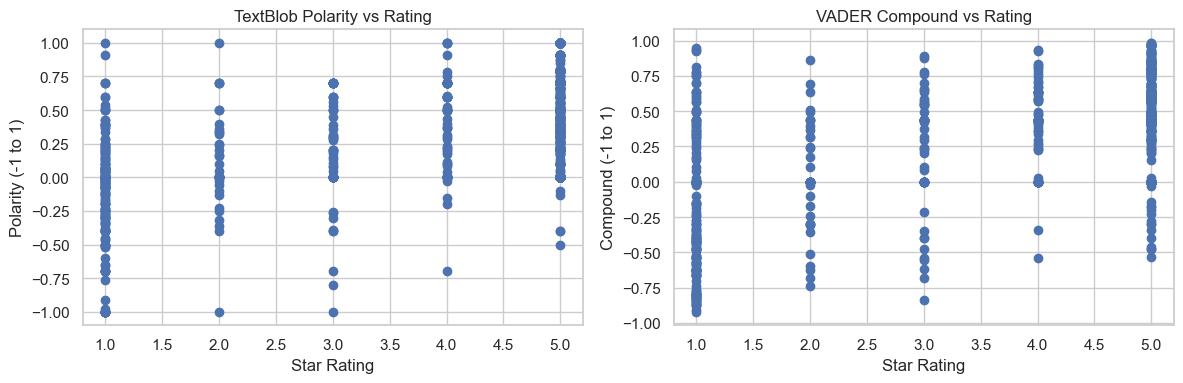

In [31]:
# Cell 13: See how lexicon scores correlate with star rating

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(df["rating"], df["tb_polarity"])
axes[0].set_title("TextBlob Polarity vs Rating")
axes[0].set_xlabel("Star Rating")
axes[0].set_ylabel("Polarity (-1 to 1)")

axes[1].scatter(df["rating"], df["vader_compound"])
axes[1].set_title("VADER Compound vs Rating")
axes[1].set_xlabel("Star Rating")
axes[1].set_ylabel("Compound (-1 to 1)")

plt.tight_layout()
plt.show()
